In [74]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsClassifier

import datetime

In [2]:
X_train = pd.read_csv('../data/processed/X_train.csv', index_col='occupation')
y_train = pd.read_csv('../data/processed/y_train.csv', index_col='occupation')
X_test = pd.read_csv('../data/processed/X_test.csv', index_col='occupation')
y_test = pd.read_csv('../data/processed/y_test.csv', index_col='occupation')

In [3]:
X_train.shape, X_test.shape

((95228, 82), (40813, 82))

In [4]:
y_train.shape, y_test.shape

((95228, 1), (40813, 1))

# Baseline Model

In [11]:
# Use the mean as a baseline model
pipe_mean. = make_pipeline(MinMaxScaler(),
                         DummyRegressor(strategy='mean'))

In [13]:
cv_mean = cross_validate(pipe_mean, X_train, y_train, cv=5)

cv_mean_scores = cv_mean['test_score']
cv_mean_scores

array([-2.82847634e-06, -6.42477611e-05, -8.64583284e-05, -6.29658705e-05,
       -5.56993366e-05])

In [7]:
np.mean(cv_mean_scores), np.std(cv_mean_scores)

(-5.443995459146756e-05, 2.7782697139993075e-05)

In [8]:
np.round((np.mean(cv_mean_scores) - 2 * np.std(cv_mean_scores), np.mean(cv_mean_scores) + 2 * np.std(cv_mean_scores)), 2)

array([-0.,  0.])

# Linear Model 

In [14]:
# Linear Regression
pipe_lm = make_pipeline(MinMaxScaler(),
                       LinearRegression())

In [15]:
cv_lm = cross_validate(pipe_lm, X_train, y_train, cv=5)

cv_lm_scores = cv_lm['test_score']
cv_lm_scores

array([0.60365132, 0.60699329, 0.60608191, 0.60564679, 0.60923612])

In [16]:
np.mean(cv_lm_scores), np.std(cv_lm_scores)

(0.6063218883635016, 0.0018214711567256213)

In [17]:
np.round((np.mean(cv_lm_scores) - 2 * np.std(cv_lm_scores), np.mean(cv_lm_scores) + 2 * np.std(cv_lm_scores)), 2)

array([0.6 , 0.61])

In [22]:
pipe_lm.fit(X_train, y_train)
y_tr_line_pred = pipe_lm.predict(X_train)

In [23]:
# R_squared error
r2_score(y_train, y_tr_line_pred)

0.6070916246133975

In [24]:
# MAE of training data
mean_absolute_error(y_train, y_tr_line_pred)

14256.847093961414

In [25]:
# MSE of training data
mean_squared_error(y_train, y_tr_line_pred)

422343367.20089674

# Linear Regression and dimensions

In [26]:
# Define pipeline (linear regression)
pipe_reg = make_pipeline(
    MinMaxScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

### Cross-validate

In [27]:
cv_reg = cross_validate(pipe_reg, X_train, y_train.values.ravel(), cv=5)

cv_reg_scores = cv_reg['test_score']
cv_reg_scores

array([0.50477401, 0.51306317, 0.51152779, 0.51006312, 0.50792524])

In [28]:
np.mean(cv_reg_scores), np.std(cv_reg_scores)

(0.5094706663722525, 0.002896058875524491)

In [29]:
np.round((np.mean(cv_reg_scores) - 2 * np.std(cv_reg_scores), np.mean(cv_reg_scores) + 2 * np.std(cv_reg_scores)), 2)

array([0.5 , 0.52])

### Hyperparameter search using GridSearchCV

In [30]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [31]:
reg_grid_cv = GridSearchCV(pipe_reg, param_grid=grid_params, cv=5, n_jobs=-1)

In [32]:
reg_grid_cv.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000023C78455EE0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [33]:
score_mean = reg_grid_cv.cv_results_['mean_test_score']
score_std = reg_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in reg_grid_cv.cv_results_['param_selectkbest__k']]

In [34]:
reg_grid_cv.best_params_

{'selectkbest__k': 82}

In [41]:
reg_best_cv_results = cross_validate(reg_grid_cv.best_estimator_, X_train, y_train.values.ravel(), cv=5)
reg_best_scores = reg_best_cv_results['test_score']
reg_best_scores

array([0.60365132, 0.60699329, 0.60608191, 0.60564679, 0.60923612])

In [42]:
np.mean(reg_best_scores), np.std(reg_best_scores)

(0.6063218883635016, 0.0018214711567256213)

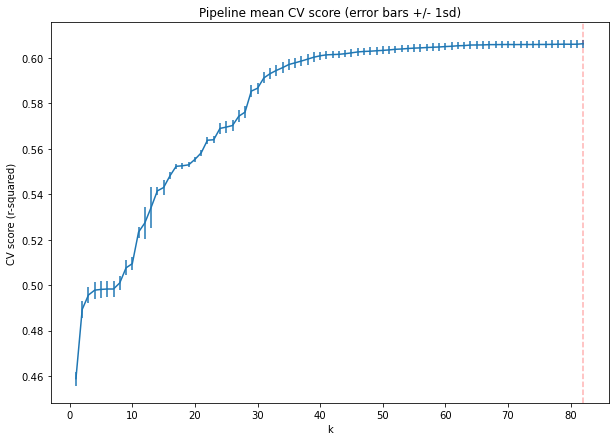

In [35]:
best_k = reg_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 7))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.3)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [36]:
selected = reg_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [37]:
coefs = reg_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
most_important = pd.Series(coefs, index=features).sort_values(ascending=False)
most_important[:15]

Management of Financial Resources    54338.626480
Science                              41192.035716
Judgment and Decision Making         36809.624092
Persuasion                           35218.222749
Critical Thinking                    28431.693271
Active Learning                      22685.603616
Reading Comprehension                22369.108770
Management of Personnel Resources    21606.376076
Time Management                      19296.807846
Monitoring                           15198.278796
Systems Evaluation                   13761.458470
Speaking                             11095.404170
Complex Problem Solving               5710.209510
C_DC                                  4924.494524
C_CA                                  2872.364145
dtype: float64

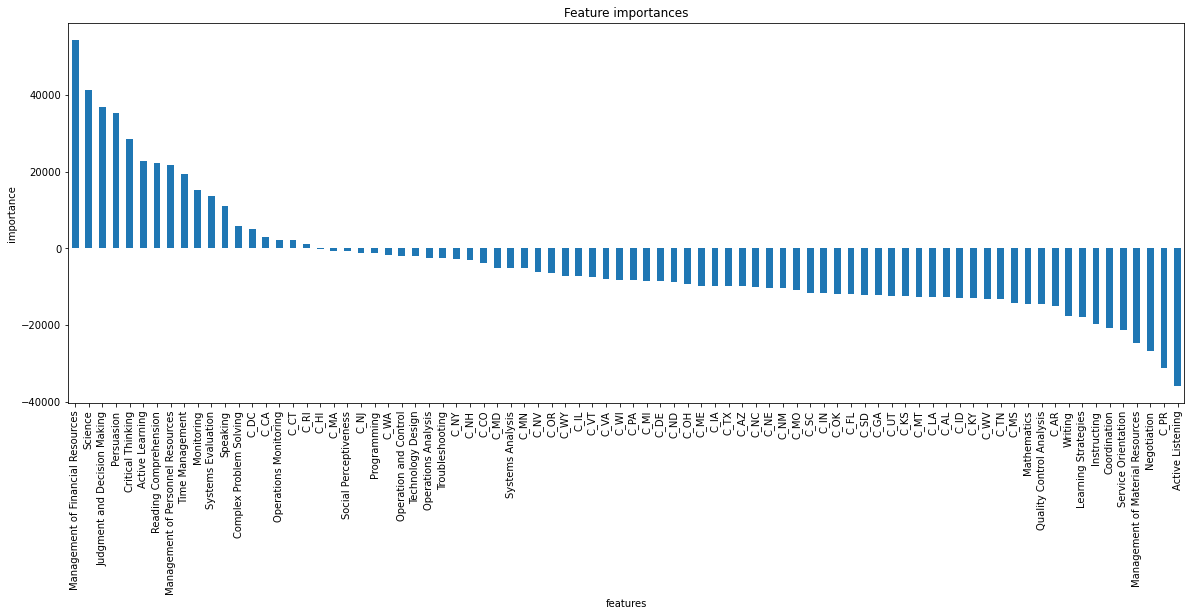

In [38]:
plt.subplots(figsize=(20, 7))
most_important.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importances');

# K-nearest Neighbors

In [50]:
# Define pipeline
pipe_knn = make_pipeline(
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=5)
)

### Cross-validate

In [51]:
cv_knn = cross_validate(pipe_knn, X_train, y_train.values.ravel(), cv=5)

cv_knn_scores = cv_knn['test_score']
cv_knn_scores

C:\Users\shine\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


array([0.00278274, 0.0023627 , 0.0023102 , 0.00341297, 0.00346548])

In [52]:
np.mean(cv_knn_scores), np.std(cv_knn_scores)

(0.002866815903032514, 0.0004955208743914123)

In [53]:
np.round((np.mean(cv_knn_scores) - 2 * np.std(cv_knn_scores), np.mean(cv_knn_scores) + 2 * np.std(cv_knn_scores)), 2)

array([0., 0.])

### Hyperparameter search using GridSearchCV

In [58]:
grid_param={'kneighborsclassifier__n_neighbors': np.arange(1,50)}
knn_grid_cv = GridSearchCV(pipe_knn, param_grid=grid_param, cv=5, n_jobs=-1)
knn_grid_cv.fit(X_train, y_train.values.ravel())

C:\Users\shine\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [59]:
knn_grid_cv.best_params_

{'kneighborsclassifier__n_neighbors': 49}

In [67]:
pipe_knn.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'kneighborsclassifier', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [69]:
knn_best_cv_results = cross_validate(knn_grid_cv.best_estimator_, X_train, y_train.values.ravel(), cv=5)
knn_best_scores = knn_best_cv_results['test_score']
knn_best_scores

C:\Users\shine\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


array([0.00488292, 0.00535546, 0.00525045, 0.00593332, 0.00535574])

In [70]:
np.mean(knn_best_scores), np.std(knn_best_scores)

(0.005355573758818069, 0.0003371183722817398)

# Random Forest Model

In [72]:
# Define pipeline (random forest)
pipe_rf = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(random_state=42)
)

In [75]:
cv_rf = cross_validate(pipe_rf, X_train, y_train.values.ravel(), cv=5)

cv_rf_scores = cv_rf['test_score']
cv_rf_scores

array([0.88380804, 0.89273923, 0.88879779, 0.88759428, 0.88469459])

In [76]:
np.mean(cv_rf_scores), np.std(cv_rf_scores)

(0.8875267860497988, 0.0031824517006334503)

In [77]:
np.round((np.mean(cv_rf_scores) - 2 * np.std(cv_rf_scores), np.mean(cv_rf_scores) + 2 * np.std(cv_rf_scores)), 2)

array([0.88, 0.89])

## Hyperparameter search using GridSearchCV

In [78]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'minmaxscaler': [MinMaxScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'minmaxscaler': [MinMaxScaler(), None]}

In [80]:
rf_grid_cv = RandomizedSearchCV(pipe_rf, param_distributions=grid_params, cv=5, n_jobs=-1, random_state=42)

In [ ]:
rf_grid_cv.fit(X_train, y_train)

In [ ]:
rf_grid_cv.best_params_

In [ ]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

In [ ]:
np.mean(rf_best_scores), np.std(rf_best_scores)

In [ ]:
coefs = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
features = X_train.columns
most_important = pd.Series(coefs, index=features).sort_values(ascending=False)
most_important[:15]

In [ ]:
plt.subplots(figsize=(20, 7))
rf_feat_imps = pd.Series(coefs, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [ ]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [ ]:
filename = '../models/skill_salary_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)